<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/rnn/music_generation_chord_duration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get -qq update
!apt-get -qq install musescore
!apt-get -qq install xvfb
!sh -e /etc/init.d/x11-common start
!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:6 http://ppa.launchpad.net/mscore-ubuntu/mscore-stable/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 252 kB i

In [57]:
!pip install -Uqq bs4
!pip install -Uqq music21
!pip install -Uqq tensorflow-addons
!pip install -Uqq "tqdm>=4.36.1"

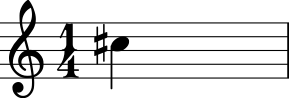

In [3]:
import os
from music21 import *

os.putenv('DISPLAY', ':99.0')
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'
n = note.Note('C#5')
n.show()

In [58]:
import time
import os
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from pathlib import Path
from urllib.request import urlopen
from urllib.request import urlretrieve
from bs4 import BeautifulSoup
from music21 import converter
from music21 import instrument
from music21 import midi
from tqdm import tqdm

In [5]:
DATASET_PATH = Path('dataset/')
try:
  os.mkdir(DATASET_PATH)
except FileExistsError:
  # dataset directory already exists
  pass

In [6]:
url0 = 'https://www.mutopiaproject.org/cgibin/make-table.cgi?startat='
url_query_p1 = '&searchingfor=&Composer=&Instrument=Guitar&Style=&collection='
url_query_p2 = '&id=&solo=&recent=&timelength=&timeunit=&lilyversion=&preview='
url1 = url_query_p1 + url_query_p2

In [7]:
song_number = 0
link_count = 10

while link_count > 0:
  url = f'{url0}{song_number}{url1}'
  html = urlopen(url)
  soup = BeautifulSoup(html.read())
  links = soup.find_all('a')
  link_count = 0
  for link in links:
    href = link['href']
    if href.find('.mid') >= 0:
      link_count += 1
      file_name = os.path.basename(href)
      urlretrieve(href, DATASET_PATH/file_name)
  song_number += 10
  time.sleep(0.5)
  

## Discrete Music Representation

### Notes

A **note** is a symbolic representation of a sound. For our purposes, a `note` can be `described by` its `pitch` and `duration`. A note's **pitch** is related to the frequency of oscillation of its sound wave, which is measured in hertz (Hz). Notes with higher pitches have sound waves with more oscillations per second. A note's duration is the length of the period over which it is played.

**MIDI files** represent a note's pitch with an integer between 0 and 127. Notes may also be represented by a pitch letter and octave number. Within the same octave, the pitches are ordered from lowest to highest frequency as follows:

lowest | to | highests
--- | --- | ---
1. C | 5. E R | 9. Ab/G#
2. C#/Db | 6. F | 10.A
3. D | 7. F#/Gb | 11.Bb/A#
4. Eb/D# | 8. G | 12. B

The **octave** is indicated by a subscript, such as the 4 in $A_4$ or the 7 in $C_7$. A higher octave corresponds to a higher frequency. If we take an arbitrary pitch, $X_i$, then the pitch $X_{i+1}$, which is exactly one octave higher, represents a sound wave with twice the frequency of $X_i$.

In addition to a note's pitch, we will also make use of its duration. The duration is a relative value, which is normalized by the length of a whole note. The longest note is a "large" note, which is eight times as long as a whole note. The shortest note is a two hundred fifty-sixth note, which is 1/256th the length of a whole note.

### Chords

A **chord** is a combination of two or more notes played simultaneously on the same instrument. If we look at monophonic music -- that is, music played on a single instrument -- we may identify chords by assuming that all notes played at the exact same time are part of the same chord. This assumption is not valid if we have polyphonic music, which consists of two or more instruments playing simultaneously.

In the code block below, we install music21 and then import the converter module, which we will use to parse MIDI files. We will load and parse a classical guitar piece by Mauro Giuliani. We will then apply the .chordify() method, which reconstructs the sequence of chords in the score, assuming that notes played simultaneously are part of the same chord.

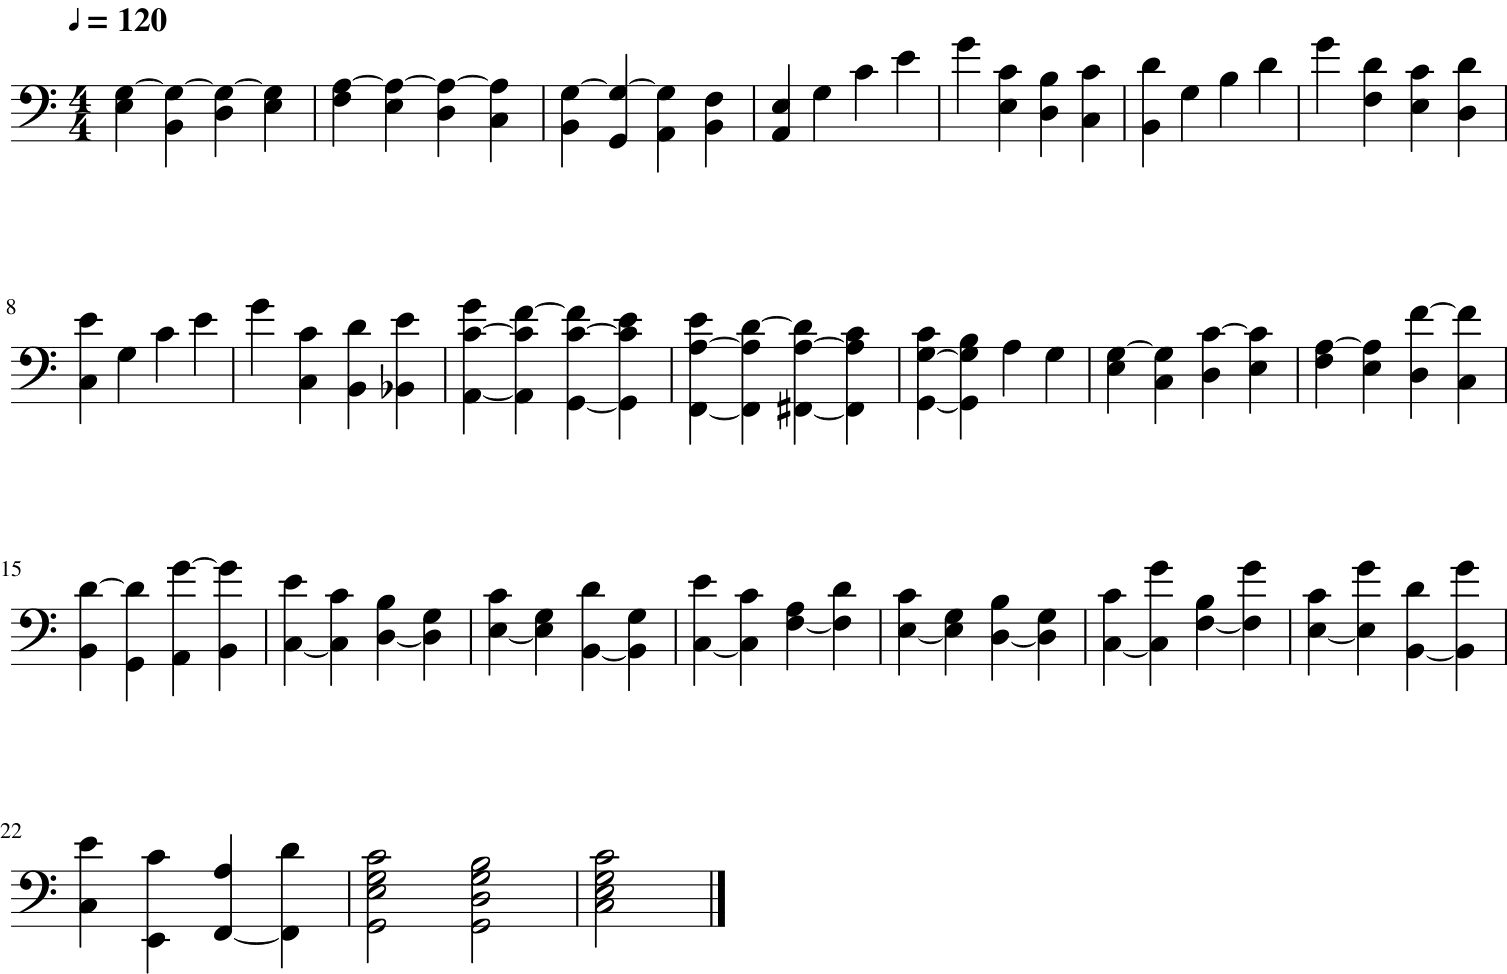

In [8]:
score = converter.parse(DATASET_PATH/'giuliani-o51-01.mid').chordify()
score.show()

In [9]:
score.show('text')

{0.0} <music21.instrument.Guitar 'Guitar'>
{0.0} <music21.instrument.Instrument ''>
{0.0} <music21.instrument.AcousticGuitar 'acoustic guitar (nylon)'>
{0.0} <music21.instrument.Guitar 'Guitar'>
{0.0} <music21.tempo.MetronomeMark animato Quarter=120.0>
{0.0} <music21.key.Key of C major>
{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.chord.Chord E3 G3>
{1.0} <music21.chord.Chord B2 G3>
{2.0} <music21.chord.Chord D3 G3>
{3.0} <music21.chord.Chord E3 G3>
{4.0} <music21.chord.Chord F3 A3>
{5.0} <music21.chord.Chord E3 A3>
{6.0} <music21.chord.Chord D3 A3>
{7.0} <music21.chord.Chord C3 A3>
{8.0} <music21.chord.Chord B2 G3>
{9.0} <music21.chord.Chord G2 G3>
{10.0} <music21.chord.Chord A2 G3>
{11.0} <music21.chord.Chord B2 F3>
{12.0} <music21.chord.Chord A2 E3>
{13.0} <music21.chord.Chord G3>
{14.0} <music21.chord.Chord C4>
{15.0} <music21.chord.Chord E4>
{16.0} <music21.chord.Chord G4>
{17.0} <music21.chord.Chord E3 C4>
{18.0} <music21.chord.Chord D3 B3>
{19.0} <music21.chord.Chord C

In [10]:
score.elements[10]

<music21.chord.Chord E3 G3>

In [11]:
score.elements[10].duration

<music21.duration.Duration 1.0>

In [12]:
song_list = os.listdir(DATASET_PATH)

original_scores = [converter.parse(DATASET_PATH/song) 
                    for song in song_list if song.lower().find('giuliani') > -1]
print('Total <giuliani> songs found:',len(original_scores))

Total <giuliani> songs found: 88


In [13]:
def monophonic(stream):
  try:
    length = len(instrument.partitionByInstrument(stream).parts)
  except:
    length = 0
  return length == 1

In [14]:
monophonic_scores = [song.chordify() 
                      for song in original_scores if monophonic(song)]
print('Monophonic songs:', len(monophonic_scores))

Monophonic songs: 32


In [15]:
def extract_chords(song):
  chords = []
  for element in song:
    if isinstance(element, note.Note):
      chords.append(element.pitch)
    elif isinstance(element, chord.Chord):
      chords.append('.'.join(str(p) for p in element.pitches))
  return chords

In [16]:
def extract_durations(song):
  durations = []
  for element in song:
    if isinstance(element, note.Note) or isinstance(element, chord.Chord):
      durations.append(element.duration.quarterLength)
  return durations

In [17]:
monophonic_keys = [str(song.analyze('key')) for song in monophonic_scores]
monophonic_chords = [extract_chords(song) for song in monophonic_scores]
monophonic_durations = [extract_durations(song) for song in monophonic_scores]

In [18]:
c_major_chords = [c for c, k in zip(monophonic_chords, monophonic_keys) 
                  if k == 'C major']
c_major_durations = [d for d, k in zip(monophonic_durations, monophonic_keys) 
                  if k == 'C major']

In [19]:
unique_chords = set([c for chords in c_major_chords for c in chords])
chord_to_int = dict(zip(unique_chords, list(range(0, len(unique_chords)))))
int_to_chord = {i: c for c, i in chord_to_int.items()}

unique_durations = set([d for ds in c_major_durations for d in ds])
duration_to_int = dict(zip(unique_durations, list(range(0, len(unique_durations)))))
int_to_duration = {i: d for d, i in duration_to_int.items()}

print('Unique chords', len(unique_chords))
print('Unique durations', len(unique_durations))

Unique chords 139
Unique durations 10


In [20]:
CHORD_VOCAB_SIZE = len(unique_chords)
DURATION_VOCAB_SIZE = len(unique_durations)
EMBEDDING_SIZE = 64
LSTM_MEMORY_UNITS = 512
DENSE_SIZE = 256
BATCH_SIZE = 4
SEQUENCE_LENGTH = 32

In [21]:
#concatenated_songs_chords = np.concatenate(c_major_chords)
concatenated_songs_chords = np.array([chord_to_int[chord] for song in c_major_chords for chord in song])
concatenated_songs_durations = np.array([duration_to_int[duration] for song in c_major_durations for duration in song])
print('Concatenated songs chords shape:', concatenated_songs_chords.shape)
print('Concatenated songs durations shape:', concatenated_songs_durations.shape) 

Concatenated songs chords shape: (1571,)
Concatenated songs durations shape: (1571,)


In [22]:
def get_batch(vectorized_songs, seq_length, batch_size):
  # length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1

  # randomly choose the starting indices for the examples in the training
  idx = np.random.choice(n - seq_length, batch_size)

  input_batch = [vectorized_songs[s: s + seq_length] 
                 for _, s in enumerate(idx)]

  output_batch = [vectorized_songs[s + 1: s + 1 + seq_length] 
                  for _, s in enumerate(idx)]
  
  X_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return X_batch, y_batch

# get_batch "unit test"
test_batch_size = 3
test_sequence_length = 5
fake_concatenated_songs = np.random.randint(1, 100, 100)
X_test_batch, y_test_batch = get_batch(
    fake_concatenated_songs, test_sequence_length, test_batch_size
)
assert X_test_batch.shape == (test_batch_size, test_sequence_length)

X_test_batch, y_test_batch = get_batch(
    concatenated_songs_chords, test_sequence_length, test_batch_size
)
assert X_test_batch.shape == (test_batch_size, test_sequence_length)


In [23]:
chord_input = Input(shape=(SEQUENCE_LENGTH,), batch_size=BATCH_SIZE, name='chord_input')

duration_input = Input(shape=(SEQUENCE_LENGTH,), batch_size=BATCH_SIZE, name='duration_input')

chord_embedding = Embedding(CHORD_VOCAB_SIZE, EMBEDDING_SIZE)(chord_input)

duration_embedding = Embedding(
    DURATION_VOCAB_SIZE,
    EMBEDDING_SIZE
)(duration_input)

merge_layer = Concatenate(axis=-1)([chord_embedding, duration_embedding])

lstm_layer = LSTM(
    LSTM_MEMORY_UNITS,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    stateful=False  # should be True???
)(merge_layer)


dense_layer = Dense(DENSE_SIZE)(lstm_layer)

chord_output = Dense(CHORD_VOCAB_SIZE, name='chord_output')(dense_layer)

duration_output = Dense(DURATION_VOCAB_SIZE, name='duration_output')(dense_layer)

lstm = Model(
    inputs = [chord_input, duration_input], 
    outputs = [chord_output, duration_output]
)

In [24]:
lstm.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
chord_input (InputLayer)        [(4, 32)]            0                                            
__________________________________________________________________________________________________
duration_input (InputLayer)     [(4, 32)]            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (4, 32, 64)          8896        chord_input[0][0]                
__________________________________________________________________________________________________
embedding_1 (Embedding)         (4, 32, 64)          640         duration_input[0][0]             
_______________________________________________________________________________________

In [25]:
X_chords, y_chords = get_batch(concatenated_songs_chords, SEQUENCE_LENGTH, BATCH_SIZE * 1000)
X_durations, y_durations = get_batch(concatenated_songs_durations, SEQUENCE_LENGTH, BATCH_SIZE * 1000)
y_chords_pred, y_durations_pred = lstm([X_chords, X_durations], [y_chords, y_durations])
y_chords_pred.shape, y_durations_pred.shape

(TensorShape([4000, 32, 139]), TensorShape([4000, 32, 10]))

In [26]:
for i, (input_idx, target_idx) in enumerate(zip(X_chords[0][:3], y_chords[0][:3])):
  print('Step:', i)
  print(f'input: {input_idx} ({int_to_chord[input_idx]})')
  print(f'expected output: {target_idx} ({int_to_chord[target_idx]})')

Step: 0
input: 11 (E4.C5)
expected output: 17 (G4.C5)
Step: 1
input: 17 (G4.C5)
expected output: 18 (C4)
Step: 2
input: 18 (C4)
expected output: 21 (C4.G4)


In [27]:
def compute_loss(labels, logits):
  loss = SparseCategoricalCrossentropy(from_logits=True)
  return loss(labels, logits)

In [28]:
loss_chords = compute_loss(y_chords, y_chords_pred)
loss_durations = compute_loss(y_durations, y_durations_pred)

loss_chords.numpy(), loss_durations.numpy()

(4.9348865, 2.303352)

In [29]:
lstm.compile(
    optimizer='rmsprop',
    loss={
        'chord_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        'duration_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    },
    metrics=['accuracy']
)

In [30]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

history = lstm.fit(
    {'chord_input': X_chords, 'duration_input': X_durations},
    {'chord_output': y_chords, 'duration_output': y_durations},
    epochs=100,
    batch_size=4,
    callbacks=[tqdm_callback],
)

Epoch 1/100


Epoch 1/100
1000/1000 [==============================] - 7s 7ms/step - loss: 2.0336 - chord_output_loss: 1.7545 - duration_output_loss: 0.2791 - chord_output_accuracy: 0.5602 - duration_output_accuracy: 0.9385
Epoch 2/100


Epoch 2/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4698 - chord_output_loss: 0.2777 - duration_output_loss: 0.1921 - chord_output_accuracy: 0.9227 - duration_output_accuracy: 0.9550
Epoch 3/100


Epoch 3/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3662 - chord_output_loss: 0.1951 - duration_output_loss: 0.1711 - chord_output_accuracy: 0.9422 - duration_output_accuracy: 0.9598
Epoch 4/100


Epoch 4/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3287 - chord_output_loss: 0.1699 - duration_output_loss: 0.1588 - chord_output_accuracy: 0.9483 - duration_output_accuracy: 0.9632
Epoch 5/100


Epoch 5/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3036 - chord_output_loss: 0.1556 - duration_output_loss: 0.1481 - chord_output_accuracy: 0.9515 - duration_output_accuracy: 0.9664
Epoch 6/100


Epoch 6/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2832 - chord_output_loss: 0.1453 - duration_output_loss: 0.1379 - chord_output_accuracy: 0.9542 - duration_output_accuracy: 0.9694
Epoch 7/100


Epoch 7/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2662 - chord_output_loss: 0.1410 - duration_output_loss: 0.1252 - chord_output_accuracy: 0.9551 - duration_output_accuracy: 0.9722
Epoch 8/100


Epoch 8/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2501 - chord_output_loss: 0.1352 - duration_output_loss: 0.1148 - chord_output_accuracy: 0.9562 - duration_output_accuracy: 0.9748
Epoch 9/100


Epoch 9/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2398 - chord_output_loss: 0.1330 - duration_output_loss: 0.1067 - chord_output_accuracy: 0.9567 - duration_output_accuracy: 0.9758
Epoch 10/100


Epoch 10/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2299 - chord_output_loss: 0.1309 - duration_output_loss: 0.0990 - chord_output_accuracy: 0.9573 - duration_output_accuracy: 0.9773
Epoch 11/100


Epoch 11/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2218 - chord_output_loss: 0.1288 - duration_output_loss: 0.0930 - chord_output_accuracy: 0.9577 - duration_output_accuracy: 0.9780
Epoch 12/100


Epoch 12/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2150 - chord_output_loss: 0.1280 - duration_output_loss: 0.0869 - chord_output_accuracy: 0.9575 - duration_output_accuracy: 0.9791
Epoch 13/100


Epoch 13/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2080 - chord_output_loss: 0.1253 - duration_output_loss: 0.0827 - chord_output_accuracy: 0.9590 - duration_output_accuracy: 0.9793
Epoch 14/100


Epoch 14/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2024 - chord_output_loss: 0.1243 - duration_output_loss: 0.0781 - chord_output_accuracy: 0.9593 - duration_output_accuracy: 0.9806
Epoch 15/100


Epoch 15/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1987 - chord_output_loss: 0.1243 - duration_output_loss: 0.0744 - chord_output_accuracy: 0.9592 - duration_output_accuracy: 0.9810
Epoch 16/100


Epoch 16/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1944 - chord_output_loss: 0.1229 - duration_output_loss: 0.0715 - chord_output_accuracy: 0.9594 - duration_output_accuracy: 0.9816
Epoch 17/100


Epoch 17/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1917 - chord_output_loss: 0.1225 - duration_output_loss: 0.0692 - chord_output_accuracy: 0.9597 - duration_output_accuracy: 0.9816
Epoch 18/100


Epoch 18/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1882 - chord_output_loss: 0.1214 - duration_output_loss: 0.0668 - chord_output_accuracy: 0.9596 - duration_output_accuracy: 0.9821
Epoch 19/100


Epoch 19/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1855 - chord_output_loss: 0.1216 - duration_output_loss: 0.0639 - chord_output_accuracy: 0.9599 - duration_output_accuracy: 0.9825
Epoch 20/100


Epoch 20/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1832 - chord_output_loss: 0.1209 - duration_output_loss: 0.0624 - chord_output_accuracy: 0.9603 - duration_output_accuracy: 0.9826
Epoch 21/100


Epoch 21/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1809 - chord_output_loss: 0.1205 - duration_output_loss: 0.0604 - chord_output_accuracy: 0.9598 - duration_output_accuracy: 0.9828
Epoch 22/100


Epoch 22/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1779 - chord_output_loss: 0.1195 - duration_output_loss: 0.0584 - chord_output_accuracy: 0.9606 - duration_output_accuracy: 0.9830
Epoch 23/100


Epoch 23/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1766 - chord_output_loss: 0.1198 - duration_output_loss: 0.0567 - chord_output_accuracy: 0.9604 - duration_output_accuracy: 0.9835
Epoch 24/100


Epoch 24/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1743 - chord_output_loss: 0.1188 - duration_output_loss: 0.0555 - chord_output_accuracy: 0.9608 - duration_output_accuracy: 0.9837
Epoch 25/100


Epoch 25/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1721 - chord_output_loss: 0.1181 - duration_output_loss: 0.0540 - chord_output_accuracy: 0.9609 - duration_output_accuracy: 0.9838
Epoch 26/100


Epoch 26/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1721 - chord_output_loss: 0.1188 - duration_output_loss: 0.0533 - chord_output_accuracy: 0.9607 - duration_output_accuracy: 0.9841
Epoch 27/100


Epoch 27/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1707 - chord_output_loss: 0.1186 - duration_output_loss: 0.0521 - chord_output_accuracy: 0.9606 - duration_output_accuracy: 0.9845
Epoch 28/100


Epoch 28/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1691 - chord_output_loss: 0.1176 - duration_output_loss: 0.0515 - chord_output_accuracy: 0.9611 - duration_output_accuracy: 0.9845
Epoch 29/100


Epoch 29/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1681 - chord_output_loss: 0.1179 - duration_output_loss: 0.0502 - chord_output_accuracy: 0.9610 - duration_output_accuracy: 0.9848
Epoch 30/100


Epoch 30/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1663 - chord_output_loss: 0.1174 - duration_output_loss: 0.0489 - chord_output_accuracy: 0.9610 - duration_output_accuracy: 0.9850
Epoch 31/100


Epoch 31/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1663 - chord_output_loss: 0.1177 - duration_output_loss: 0.0486 - chord_output_accuracy: 0.9611 - duration_output_accuracy: 0.9849
Epoch 32/100


Epoch 32/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1645 - chord_output_loss: 0.1165 - duration_output_loss: 0.0480 - chord_output_accuracy: 0.9619 - duration_output_accuracy: 0.9850
Epoch 33/100


Epoch 33/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1647 - chord_output_loss: 0.1176 - duration_output_loss: 0.0472 - chord_output_accuracy: 0.9614 - duration_output_accuracy: 0.9853
Epoch 34/100


Epoch 34/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1632 - chord_output_loss: 0.1167 - duration_output_loss: 0.0465 - chord_output_accuracy: 0.9611 - duration_output_accuracy: 0.9856
Epoch 35/100


Epoch 35/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1631 - chord_output_loss: 0.1175 - duration_output_loss: 0.0456 - chord_output_accuracy: 0.9614 - duration_output_accuracy: 0.9859
Epoch 36/100


Epoch 36/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1606 - chord_output_loss: 0.1159 - duration_output_loss: 0.0447 - chord_output_accuracy: 0.9620 - duration_output_accuracy: 0.9855
Epoch 37/100


Epoch 37/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1618 - chord_output_loss: 0.1165 - duration_output_loss: 0.0453 - chord_output_accuracy: 0.9611 - duration_output_accuracy: 0.9857
Epoch 38/100


Epoch 38/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1604 - chord_output_loss: 0.1161 - duration_output_loss: 0.0443 - chord_output_accuracy: 0.9615 - duration_output_accuracy: 0.9860
Epoch 39/100


Epoch 39/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1600 - chord_output_loss: 0.1156 - duration_output_loss: 0.0444 - chord_output_accuracy: 0.9613 - duration_output_accuracy: 0.9858
Epoch 40/100


Epoch 40/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1601 - chord_output_loss: 0.1162 - duration_output_loss: 0.0438 - chord_output_accuracy: 0.9613 - duration_output_accuracy: 0.9859
Epoch 41/100


Epoch 41/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1588 - chord_output_loss: 0.1155 - duration_output_loss: 0.0433 - chord_output_accuracy: 0.9613 - duration_output_accuracy: 0.9862
Epoch 42/100


Epoch 42/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1585 - chord_output_loss: 0.1155 - duration_output_loss: 0.0430 - chord_output_accuracy: 0.9619 - duration_output_accuracy: 0.9860
Epoch 43/100


Epoch 43/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1579 - chord_output_loss: 0.1154 - duration_output_loss: 0.0425 - chord_output_accuracy: 0.9613 - duration_output_accuracy: 0.9864
Epoch 44/100


Epoch 44/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1581 - chord_output_loss: 0.1162 - duration_output_loss: 0.0420 - chord_output_accuracy: 0.9608 - duration_output_accuracy: 0.9861
Epoch 45/100


Epoch 45/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1569 - chord_output_loss: 0.1147 - duration_output_loss: 0.0422 - chord_output_accuracy: 0.9620 - duration_output_accuracy: 0.9862
Epoch 46/100


Epoch 46/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1567 - chord_output_loss: 0.1155 - duration_output_loss: 0.0412 - chord_output_accuracy: 0.9613 - duration_output_accuracy: 0.9863
Epoch 47/100


Epoch 47/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1567 - chord_output_loss: 0.1151 - duration_output_loss: 0.0416 - chord_output_accuracy: 0.9618 - duration_output_accuracy: 0.9862
Epoch 48/100


Epoch 48/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1566 - chord_output_loss: 0.1155 - duration_output_loss: 0.0411 - chord_output_accuracy: 0.9618 - duration_output_accuracy: 0.9865
Epoch 49/100


Epoch 49/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1559 - chord_output_loss: 0.1157 - duration_output_loss: 0.0401 - chord_output_accuracy: 0.9615 - duration_output_accuracy: 0.9865
Epoch 50/100


Epoch 50/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1557 - chord_output_loss: 0.1150 - duration_output_loss: 0.0407 - chord_output_accuracy: 0.9619 - duration_output_accuracy: 0.9865
Epoch 51/100


Epoch 51/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1560 - chord_output_loss: 0.1154 - duration_output_loss: 0.0406 - chord_output_accuracy: 0.9614 - duration_output_accuracy: 0.9864
Epoch 52/100


Epoch 52/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1560 - chord_output_loss: 0.1157 - duration_output_loss: 0.0403 - chord_output_accuracy: 0.9617 - duration_output_accuracy: 0.9867
Epoch 53/100


Epoch 53/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1553 - chord_output_loss: 0.1151 - duration_output_loss: 0.0402 - chord_output_accuracy: 0.9616 - duration_output_accuracy: 0.9865
Epoch 54/100


Epoch 54/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1545 - chord_output_loss: 0.1149 - duration_output_loss: 0.0396 - chord_output_accuracy: 0.9615 - duration_output_accuracy: 0.9865
Epoch 55/100


Epoch 55/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1538 - chord_output_loss: 0.1147 - duration_output_loss: 0.0391 - chord_output_accuracy: 0.9617 - duration_output_accuracy: 0.9866
Epoch 56/100


Epoch 56/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1539 - chord_output_loss: 0.1143 - duration_output_loss: 0.0395 - chord_output_accuracy: 0.9619 - duration_output_accuracy: 0.9866
Epoch 57/100


Epoch 57/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1530 - chord_output_loss: 0.1139 - duration_output_loss: 0.0391 - chord_output_accuracy: 0.9618 - duration_output_accuracy: 0.9866
Epoch 58/100


Epoch 58/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1541 - chord_output_loss: 0.1150 - duration_output_loss: 0.0390 - chord_output_accuracy: 0.9617 - duration_output_accuracy: 0.9865
Epoch 59/100


Epoch 59/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1533 - chord_output_loss: 0.1141 - duration_output_loss: 0.0392 - chord_output_accuracy: 0.9619 - duration_output_accuracy: 0.9864
Epoch 60/100


Epoch 60/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1542 - chord_output_loss: 0.1154 - duration_output_loss: 0.0388 - chord_output_accuracy: 0.9613 - duration_output_accuracy: 0.9868
Epoch 61/100


Epoch 61/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1533 - chord_output_loss: 0.1147 - duration_output_loss: 0.0385 - chord_output_accuracy: 0.9614 - duration_output_accuracy: 0.9868
Epoch 62/100


Epoch 62/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1540 - chord_output_loss: 0.1152 - duration_output_loss: 0.0388 - chord_output_accuracy: 0.9611 - duration_output_accuracy: 0.9868
Epoch 63/100


Epoch 63/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1525 - chord_output_loss: 0.1145 - duration_output_loss: 0.0380 - chord_output_accuracy: 0.9617 - duration_output_accuracy: 0.9868
Epoch 64/100


Epoch 64/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1532 - chord_output_loss: 0.1148 - duration_output_loss: 0.0384 - chord_output_accuracy: 0.9616 - duration_output_accuracy: 0.9867
Epoch 65/100


Epoch 65/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1530 - chord_output_loss: 0.1149 - duration_output_loss: 0.0381 - chord_output_accuracy: 0.9614 - duration_output_accuracy: 0.9865
Epoch 66/100


Epoch 66/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1524 - chord_output_loss: 0.1141 - duration_output_loss: 0.0383 - chord_output_accuracy: 0.9617 - duration_output_accuracy: 0.9868
Epoch 67/100


Epoch 67/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1525 - chord_output_loss: 0.1148 - duration_output_loss: 0.0378 - chord_output_accuracy: 0.9618 - duration_output_accuracy: 0.9870
Epoch 68/100


Epoch 68/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1524 - chord_output_loss: 0.1141 - duration_output_loss: 0.0383 - chord_output_accuracy: 0.9616 - duration_output_accuracy: 0.9868
Epoch 69/100


Epoch 69/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1512 - chord_output_loss: 0.1137 - duration_output_loss: 0.0375 - chord_output_accuracy: 0.9624 - duration_output_accuracy: 0.9871
Epoch 70/100


Epoch 70/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1518 - chord_output_loss: 0.1146 - duration_output_loss: 0.0371 - chord_output_accuracy: 0.9618 - duration_output_accuracy: 0.9871
Epoch 71/100


Epoch 71/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1521 - chord_output_loss: 0.1142 - duration_output_loss: 0.0379 - chord_output_accuracy: 0.9617 - duration_output_accuracy: 0.9868
Epoch 72/100


Epoch 72/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1512 - chord_output_loss: 0.1143 - duration_output_loss: 0.0369 - chord_output_accuracy: 0.9617 - duration_output_accuracy: 0.9868
Epoch 73/100


Epoch 73/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1514 - chord_output_loss: 0.1143 - duration_output_loss: 0.0370 - chord_output_accuracy: 0.9620 - duration_output_accuracy: 0.9870
Epoch 74/100


Epoch 74/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1514 - chord_output_loss: 0.1141 - duration_output_loss: 0.0372 - chord_output_accuracy: 0.9618 - duration_output_accuracy: 0.9869
Epoch 75/100


Epoch 75/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1500 - chord_output_loss: 0.1133 - duration_output_loss: 0.0367 - chord_output_accuracy: 0.9618 - duration_output_accuracy: 0.9871
Epoch 76/100


Epoch 76/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1513 - chord_output_loss: 0.1142 - duration_output_loss: 0.0371 - chord_output_accuracy: 0.9617 - duration_output_accuracy: 0.9870
Epoch 77/100


Epoch 77/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1514 - chord_output_loss: 0.1146 - duration_output_loss: 0.0368 - chord_output_accuracy: 0.9615 - duration_output_accuracy: 0.9873
Epoch 78/100


Epoch 78/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1500 - chord_output_loss: 0.1139 - duration_output_loss: 0.0361 - chord_output_accuracy: 0.9622 - duration_output_accuracy: 0.9870
Epoch 79/100


Epoch 79/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1507 - chord_output_loss: 0.1140 - duration_output_loss: 0.0367 - chord_output_accuracy: 0.9615 - duration_output_accuracy: 0.9870
Epoch 80/100


Epoch 80/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1507 - chord_output_loss: 0.1139 - duration_output_loss: 0.0368 - chord_output_accuracy: 0.9618 - duration_output_accuracy: 0.9871
Epoch 81/100


Epoch 81/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1508 - chord_output_loss: 0.1139 - duration_output_loss: 0.0368 - chord_output_accuracy: 0.9618 - duration_output_accuracy: 0.9868
Epoch 82/100


Epoch 82/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1505 - chord_output_loss: 0.1141 - duration_output_loss: 0.0364 - chord_output_accuracy: 0.9619 - duration_output_accuracy: 0.9870
Epoch 83/100


Epoch 83/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1509 - chord_output_loss: 0.1143 - duration_output_loss: 0.0366 - chord_output_accuracy: 0.9616 - duration_output_accuracy: 0.9870
Epoch 84/100


Epoch 84/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1492 - chord_output_loss: 0.1131 - duration_output_loss: 0.0360 - chord_output_accuracy: 0.9616 - duration_output_accuracy: 0.9871
Epoch 85/100


Epoch 85/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1505 - chord_output_loss: 0.1139 - duration_output_loss: 0.0366 - chord_output_accuracy: 0.9618 - duration_output_accuracy: 0.9869
Epoch 86/100


Epoch 86/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1504 - chord_output_loss: 0.1140 - duration_output_loss: 0.0365 - chord_output_accuracy: 0.9615 - duration_output_accuracy: 0.9872
Epoch 87/100


Epoch 87/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1507 - chord_output_loss: 0.1139 - duration_output_loss: 0.0368 - chord_output_accuracy: 0.9620 - duration_output_accuracy: 0.9868
Epoch 88/100


Epoch 88/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1503 - chord_output_loss: 0.1142 - duration_output_loss: 0.0360 - chord_output_accuracy: 0.9619 - duration_output_accuracy: 0.9873
Epoch 89/100


Epoch 89/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1498 - chord_output_loss: 0.1138 - duration_output_loss: 0.0361 - chord_output_accuracy: 0.9618 - duration_output_accuracy: 0.9872
Epoch 90/100


Epoch 90/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1495 - chord_output_loss: 0.1137 - duration_output_loss: 0.0358 - chord_output_accuracy: 0.9617 - duration_output_accuracy: 0.9870
Epoch 91/100


Epoch 91/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1504 - chord_output_loss: 0.1134 - duration_output_loss: 0.0370 - chord_output_accuracy: 0.9617 - duration_output_accuracy: 0.9868
Epoch 92/100


Epoch 92/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1501 - chord_output_loss: 0.1139 - duration_output_loss: 0.0362 - chord_output_accuracy: 0.9618 - duration_output_accuracy: 0.9870
Epoch 93/100


Epoch 93/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1495 - chord_output_loss: 0.1132 - duration_output_loss: 0.0363 - chord_output_accuracy: 0.9619 - duration_output_accuracy: 0.9870
Epoch 94/100


Epoch 94/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1498 - chord_output_loss: 0.1138 - duration_output_loss: 0.0360 - chord_output_accuracy: 0.9621 - duration_output_accuracy: 0.9870
Epoch 95/100


Epoch 95/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1497 - chord_output_loss: 0.1139 - duration_output_loss: 0.0358 - chord_output_accuracy: 0.9619 - duration_output_accuracy: 0.9871
Epoch 96/100


Epoch 96/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1503 - chord_output_loss: 0.1144 - duration_output_loss: 0.0358 - chord_output_accuracy: 0.9615 - duration_output_accuracy: 0.9871
Epoch 97/100


Epoch 97/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1497 - chord_output_loss: 0.1138 - duration_output_loss: 0.0359 - chord_output_accuracy: 0.9618 - duration_output_accuracy: 0.9873
Epoch 98/100


Epoch 98/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1500 - chord_output_loss: 0.1144 - duration_output_loss: 0.0356 - chord_output_accuracy: 0.9616 - duration_output_accuracy: 0.9874
Epoch 99/100


Epoch 99/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1498 - chord_output_loss: 0.1142 - duration_output_loss: 0.0356 - chord_output_accuracy: 0.9619 - duration_output_accuracy: 0.9873
Epoch 100/100


Epoch 100/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1507 - chord_output_loss: 0.1141 - duration_output_loss: 0.0366 - chord_output_accuracy: 0.9617 - duration_output_accuracy: 0.9871



## Generate music

1. Initialize a seed start and the RNN state, and set the number of chords we want to generate.

2. 

In [31]:
chord_seed = concatenated_songs_chords[0].copy()
duration_seed = concatenated_songs_durations[0].copy()
print(f'Chord seed: {chord_seed}  Duration seed: {duration_seed}')

Chord seed: 33  Duration seed: 0


In [32]:
def generate_chords(model, chord_seed, duration_seed, gen_length=500):
  gen_chords, gen_durations = [], []
  model.reset_states()

  input_chord = np.expand_dims([chord_seed], 0)
  input_duration = np.expand_dims([duration_seed], 0)

  with tqdm(total=gen_length, position=0, leave=True) as pbar:
    for i in tqdm(range(gen_length), position=0, leave=True):
      pred_chord, pred_duration = model( {'chord_input': input_chord, 'duration_input': input_duration})
      pred_chord = tf.squeeze(pred_chord, 0)
      pred_duration = tf.squeeze(pred_duration, 0)
      pred_chord_id = tf.random.categorical(pred_chord, num_samples=1)[-1, 0].numpy()
      pred_duration_id = tf.random.categorical(pred_duration, num_samples=1)[-1, 0].numpy()
      
      input_chord = tf.expand_dims([pred_chord_id], 0)
      input_duration = tf.expand_dims([pred_duration_id], 0)

      gen_chords.append(int_to_chord[pred_chord_id])
      gen_durations.append(int_to_duration[pred_duration_id])
      
      #print(int_to_chord[pred_chord_id], int_to_duration[pred_duration_id], end=' ')

  return gen_chords, gen_durations

In [33]:
gen_chords, gen_durations = generate_chords(lstm, chord_seed, duration_seed)

  0%|          | 0/500 [00:03<?, ?it/s]


In [34]:
# Create stream object and add guitar as instrument
generated_stream = stream.Stream()
generated_stream.append(instrument.Guitar())

# Add notes and durations to stream
for j in range(500):
    try:
        generated_stream.append(note.Note(gen_chords[j].replace('.', ' '), quarterType = gen_durations[j]))
    except:
        generated_stream.append(chord.Chord(gen_chords[j].replace('.', ' '), quarterType = gen_durations[j]))

# Export as MIDI file
generated_stream.write('midi', fp='lstm.mid')

'lstm.mid'

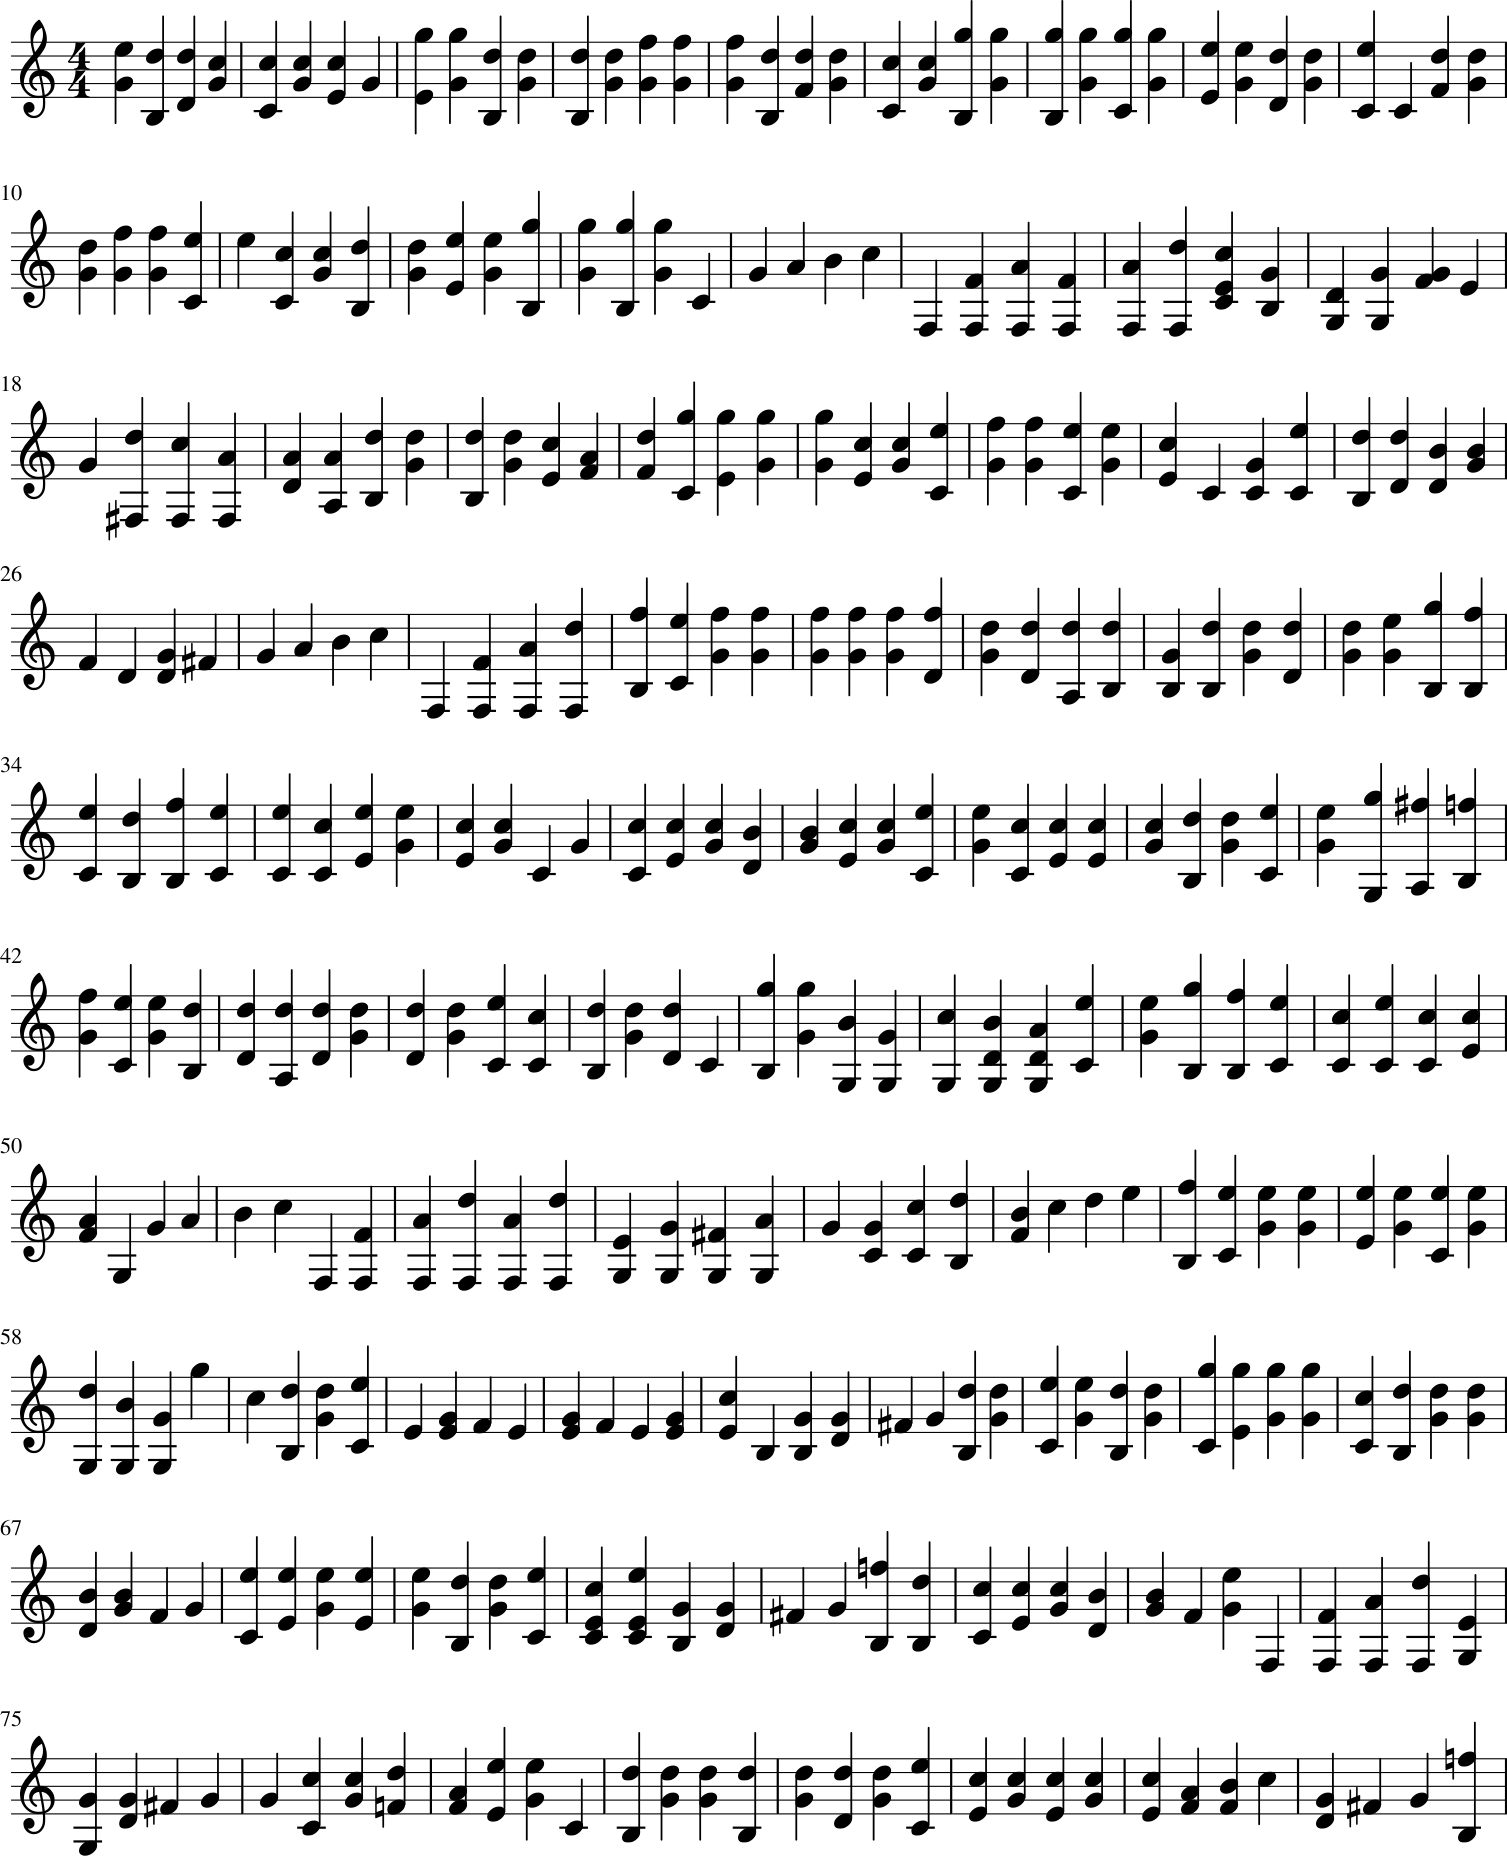

In [48]:
generated_stream.show()